# Shampoo Sales Dataset

This dataset describes the monthly number of sales of shampoo over a 3-year period.

The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998).

In [1]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset

dataset = read_csv('C:/Users/rzouga/Downloads/Github/TimeSeriesData/Shampo.csv')
# summarize first few rows
print(dataset.head())
# https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
# https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

     MonthSales
0  "1-01",266.0
1  "1-02",145.9
2  "1-03",183.1
3  "1-04",119.3
4  "1-05",180.3


In [2]:
dataset['Year'] = dataset.MonthSales.apply(lambda x: int("199"+x[1]))
dataset['Month'] = dataset.MonthSales.apply(lambda x: int(x[3:5]))
dataset['Sales'] = dataset.MonthSales.apply(lambda x: float(x[7:12]))
dataset.head()

,MonthSales,Year,Month,Sales
0,"""1-01"",266.0",1991,1,266.0
1,"""1-02"",145.9",1991,2,145.9
2,"""1-03"",183.1",1991,3,183.1
3,"""1-04"",119.3",1991,4,119.3
4,"""1-05"",180.3",1991,5,180.3


In [3]:
dataset=dataset.iloc[:,1:4]
dataset.head()

,Year,Month,Sales
0,1991,1,266.0
1,1991,2,145.9
2,1991,3,183.1
3,1991,4,119.3
4,1991,5,180.3


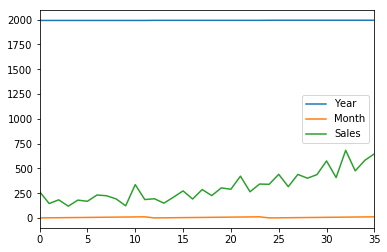

In [4]:
dataset.plot()

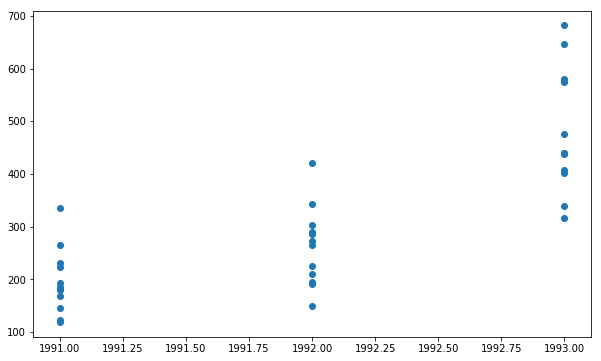

In [5]:
# Import pyplot
import matplotlib.pyplot as plt
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.scatter(dataset.Year, 
        dataset.Sales)
plt.show()

In [6]:
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')


# Pandas concat vs append vs join vs merge

    1-Concat: gives the flexibility to join based on the axis( all rows or all columns)

    2-Append: is the specific case(axis=0, join='outer') of concat

    3-Join: is based on the indexes (set by set_index) on how variable =['left','right','inner','couter']

    4-Merge: is based on any particular column each of the two dataframes, this columns are variables on like 'left_on', 'right_on', 'on'



Now that we know how to prepare data for the LSTM network, we can start developing our model.
# LSTM Model Development

The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer.

By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

    Samples: These are independent observations from the domain, typically rows of data.
    Time steps: These are separate time steps of a given variable for a given observation.
    Features: These are separate measures observed at the time of observation.

We have some flexibility in how the Shampoo Sales dataset is framed for the network. We will keep it simple and frame the problem as each time step in the original sequence is one separate sample, with one timestep and one feature.

Given that the training dataset is defined as X inputs and y outputs, it must be reshaped into the Samples/TimeSteps/Features format.
# Complete LSTM Example

In this section, we will fit an LSTM to the Shampoo Sales dataset and evaluate the model.

This will involve drawing together all of the elements from the prior sections. There are a lot of them, so let’s review:

    Load the dataset from CSV file.
    Transform the dataset to make it suitable for the LSTM model, including:
        Transforming the data to a supervised learning problem.
        Transforming the data to be stationary.
        Transforming the data so that it has the scale -1 to 1.
    Fitting a stateful LSTM network model to the training data.
    Evaluating the static LSTM model on the test data.
    Report the performance of the forecasts.

Some things to note about the example:

    The scaling and inverse scaling behaviors have been moved to the functions scale() and invert_scale() for brevity.
    The test data is scaled using the fit of the scaler on the training data, as is required to ensure the min/max values of the test data do not influence the model.
    The order of data transforms was adjusted for convenience to first make the data stationary, then a supervised learning problem, then scaled.
    Differencing was performed on the entire dataset prior to splitting into train and test sets for convenience. We could just as easily collect observations during the walk-forward validation and difference them as we go. I decided against it for readability.

The complete example is listed below.

Month=1, Predicted=249.749977, Expected=339.700000
Month=2, Predicted=393.053206, Expected=440.400000
Month=3, Predicted=319.720624, Expected=315.900000
Month=4, Predicted=377.778235, Expected=439.300000
Month=5, Predicted=302.517676, Expected=401.300000
Month=6, Predicted=457.226971, Expected=437.400000
Month=7, Predicted=382.803710, Expected=575.500000
Month=8, Predicted=351.626382, Expected=407.600000
Month=9, Predicted=380.057949, Expected=682.000000
Month=10, Predicted=383.354920, Expected=475.300000
Month=11, Predicted=434.896347, Expected=581.300000
Month=12, Predicted=294.358699, Expected=646.900000
Test RMSE: 160.699


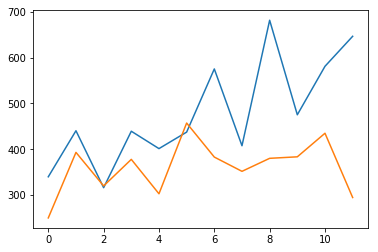

In [11]:
series = dataset.loc[:,'Sales']
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
 
from tensorflow import keras
from tensorflow.keras import layers
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 

 # transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
 #report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()